In [27]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

train_a = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_a_final.csv')
train_b = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_b_final.csv')
train_c = pd.read_csv('C:/Users/kari.abromitis/Desktop/Data Science/train_c_final.csv')


train_a = train_a.drop(['period','Day','Hour','Unnamed: 0','Minute_x_x','Second_x_x', 'Minute_y_x', 'Second_y_x', 'Minute_x_y',  'Second_x_y',  'Minute_y_y', 'Second_y_y'], axis=1)
train_a = train_a[['dst','bt_mean', 'density_mean', 'speed_mean', 'temp_mean', 'bt_std','density_std', 'speed_std', 'temp_std', 'smoothed_ssn']]
print(train_a.columns)
print(train_a)


Index(['dst', 'bt_mean', 'density_mean', 'speed_mean', 'temp_mean', 'bt_std',
       'density_std', 'speed_std', 'temp_std', 'smoothed_ssn'],
      dtype='object')
       dst   bt_mean  density_mean  speed_mean     temp_mean    bt_std  \
0       -7  6.926154      1.222692  356.591538  71071.403846  0.134312   
1      -10  7.285349      1.055814  337.480930  59333.209302  0.311512   
2      -10  7.878421      1.141053  335.142105  48582.368421  0.071112   
3       -6  7.742456      2.754211  347.815088  76768.736842  0.297209   
4       -2  6.278500      2.889500  370.297500  78039.550000  0.334747   
...    ...       ...           ...         ...           ...       ...   
27013   12  4.249474      5.078947  353.676491  26988.526316  0.497746   
27014   11  4.560909      5.041636  349.491818  33606.836364  1.079685   
27015   14  5.350727      4.681273  341.260545  36537.636364  0.502711   
27016   13  5.289455      4.444545  337.678364  38083.454545  0.335551   
27017   13  4.933393  

In [40]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = train_a
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler)
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
# print(reframed.head())

print(reframed)

MinMaxScaler()
       var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)  \
1       0.107287   0.008135   0.151799   0.041391   0.004443   0.008965   
2       0.113618   0.007013   0.123023   0.033418   0.010305   0.012429   
3       0.124072   0.007586   0.119501   0.026114   0.002353   0.006783   
4       0.121676   0.018429   0.138584   0.045262   0.009832   0.019818   
5       0.095871   0.019338   0.172437   0.046125   0.011074   0.016718   
...          ...        ...        ...        ...        ...        ...   
27013   0.066644   0.034225   0.147143   0.014478   0.023748   0.008262   
27014   0.060106   0.034055   0.147410   0.011445   0.016466   0.011762   
27015   0.065596   0.033804   0.141109   0.015941   0.035718   0.015565   
27016   0.079518   0.031382   0.128714   0.017932   0.016631   0.007556   
27017   0.078438   0.029791   0.123320   0.018982   0.011101   0.007754   

       var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1       0.061826   0.033330    0

In [41]:
# split into train and test sets

values = reframed.values
n_train_hours = round(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X)
# print(train_y)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(21506, 1, 9) (21506,) (5376, 1, 9) (5376,)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 300)               372000    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 372,301
Trainable params: 372,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
225/225 - 3s - loss: 0.1557 - accuracy: 4.6499e-05 - val_loss: 0.0537 - val_accuracy: 0.0000e+00 - 3s/epoch - 13ms/step
Epoch 2/5
225/225 - 1s - loss: 0.0565 - accuracy: 4.6499e-05 - val_loss: 0.0528 - val_accuracy: 0.0000e+00 - 1s/epoch - 5ms/step
Epoch 3/5
225/225 - 1s - loss: 0.0512 - accuracy: 4.6499e-05 - val_loss: 0.0524 - val_accuracy: 0.0000e+00 - 1s/epoch - 5ms/step
Epoch 4/5
225/225 - 1s - loss: 0.0424 - accuracy: 4.6499

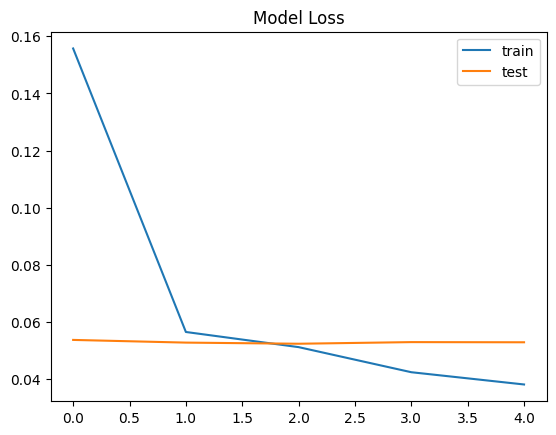

In [42]:

# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
model.summary()

# model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=96, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Model Loss")
plt.show()



In [44]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# print(inv_yhat.shape)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

168/168 [==============================] - 0s 2ms/step


ValueError: operands could not be broadcast together with shapes (5376,9) (10,) (5376,9) 

In [21]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(5376, 9)


ValueError: operands could not be broadcast together with shapes (5376,9) (10,) (5376,9) 

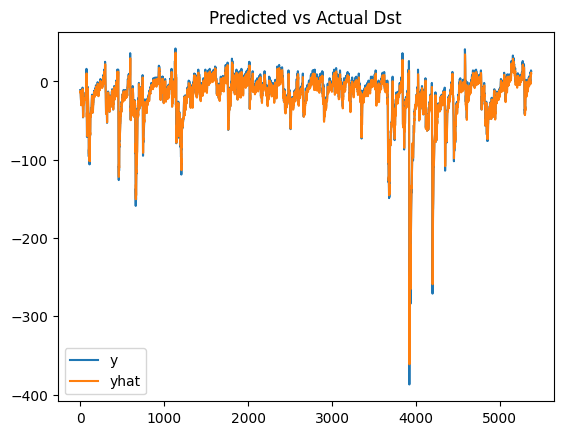

In [54]:
# pyplot.plot(inv_y, inv_yhat)
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.title("Predicted vs Actual Dst")
plt.legend()
plt.show()
plt.show()

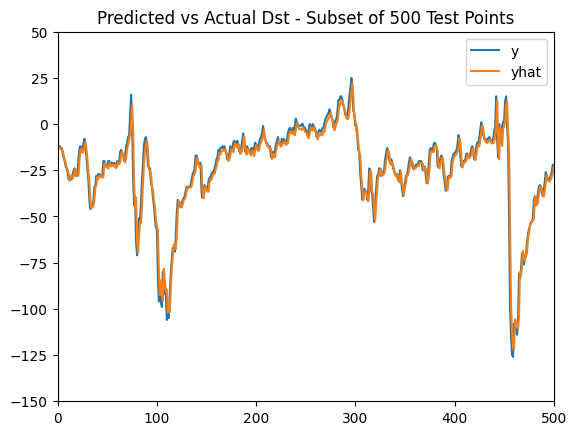

In [63]:
plt.plot(inv_y, label='y')
plt.plot(inv_yhat, label='yhat')
plt.title("Predicted vs Actual Dst - Subset of 500 Test Points")
plt.xlim([0, 500])
plt.ylim([-150, 50])
plt.legend()
plt.show()
